## Probem Statement:
### Predict the match percentage
In an era where technology plays a significant role in people’s lives, one cannot deny that it changes the way people interact and communicate with others. Today, technology has caused some significant changes in the dating world as well. Online dating is a new trend that is influencing many people around the world.<br>
As a data scientist, you are required to predict the match percentage between the users in a matrix format based on the attributes provided by the user on a dating website.

#### Note:
Based on the user’s sexual orientation, you are required to perform the following:
- If a user is heterosexual (prefers the opposite sex), then the match percentage must be 0 for this user with respect to other users of the same gender if the other users have the same behavior.
- If a user is a homosexual (prefers the same sex), then the match percentage must be 0 for this user with respect to other users of the opposite gender if the other users have the same behavior.
- The match percentage of a user with her/himself must be zero.

## Approach
We will create two matrix and then multiply these two matrix element-wise.<br>
The two matrix are - 
1. `Matrix 1: user-user similarity matrix`
    - We have a final dataframe that has all the variables which are needed for the model building
    - Setting the user ids as an index of the dataframe
    - Then we use cosine similarity on this dataframe which will results in a matrix of size 20001x2001. 
    - Convert all the diagonals elements to 0 and then convert it into a dataframe which has columns and rows as user ids with value fill as similarity score between each user.
2. `Matrix 2: binary user-user matrix`
    - The elements of this matrix are 0 or 1 based upon the condition given in the **problem's note**.
    - At last we multiply these two matrices and get our final match percentage.

In [1]:
# importing the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

import nltk
import re
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import string
string.punctuation

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',100)

### I. Matrix 1

In [2]:
# reading the data
df = pd.read_csv('/kaggle/input/predict-the-match-percentage/data.csv')

# looking at the data
df.head()

,user_id,username,age,status,sex,orientation,drinks,drugs,height,job,location,pets,smokes,language,new_languages,body_profile,education_level,dropped_out,bio,interests,other_interests,location_preference
0,fffe3100,Edith Lopez,27,single,f,gay,socially,never,66.0,medicine / health,"oakland, california",likes dogs and likes cats,no,"english (fluently), spanish (poorly), sign lan...",interested,athletic,4.0,no,bottom line i love life! i work hard and i lov...,sports,instruments,same state
1,fffe3200,Travis Young,26,single,m,gay,socially,never,68.0,other,"pleasant hill, california",likes dogs,no,"english (fluently), tagalog (okay), french (po...",interested,fit,3.0,no,"i'm a straightforward, genuine, fun loving (i'...",painting,instruments,anywhere
2,fffe3300,Agnes Smith,20,seeing someone,f,bisexual,socially,sometimes,69.0,other,"oakland, california",has dogs and likes cats,sometimes,"english (fluently), sign language (poorly), fr...",interested,fit,2.0,no,mmmmm yummy tacosss. yoga is where it's at. i ...,instruments,dancing,same city
3,fffe3400,Salvador Klaver,27,single,m,bisexual,socially,sometimes,68.0,computer / hardware / software,"daly city, california",likes dogs and likes cats,no,english,not interested,average,3.0,no,i'm a stealth geek. that special mix of techni...,sketching,acting,same city
4,fffe3500,Elana Sewell,22,single,f,bisexual,often,sometimes,68.0,other,"oakland, california",likes dogs and likes cats,yes,english,not interested,average,2.0,yes,with the whisper of the wind i was weaved into...,craft,designing,same city


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              2001 non-null   object 
 1   username             2001 non-null   object 
 2   age                  2001 non-null   int64  
 3   status               2001 non-null   object 
 4   sex                  2001 non-null   object 
 5   orientation          2001 non-null   object 
 6   drinks               2001 non-null   object 
 7   drugs                2001 non-null   object 
 8   height               2001 non-null   float64
 9   job                  2001 non-null   object 
 10  location             2001 non-null   object 
 11  pets                 2001 non-null   object 
 12  smokes               2001 non-null   object 
 13  language             2001 non-null   object 
 14  new_languages        2001 non-null   object 
 15  body_profile         2001 non-null   o

- There is no null values in any of the columns
- Most of the variables are object.

#### user id

In [4]:
# checking for duplicates
# and we see that the ids are all unique
df.user_id.nunique()

2001

---
#### username

In [5]:
# doesn't help in model
df.drop('username', axis=1, inplace=True)

---
#### age

In [6]:
df.age.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    2001.000000
mean       33.072464
std        10.483189
min        18.000000
25%        26.000000
50%        30.000000
75%        39.000000
90%        49.000000
95%        55.000000
99%        64.000000
max        69.000000
Name: age, dtype: float64

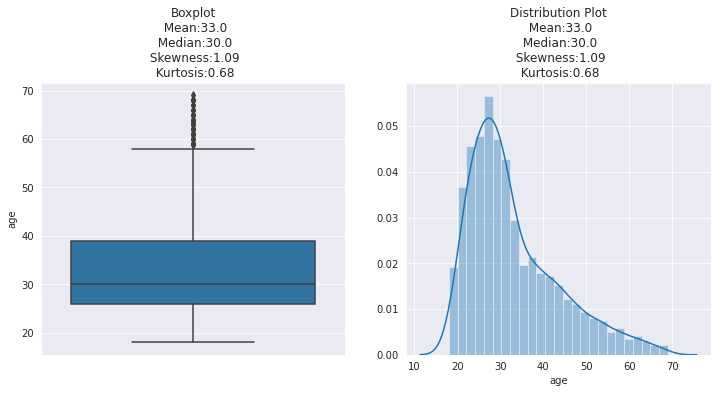

In [7]:
# Looking the distribution of column Age
plt.figure(figsize=(12,5))

skewness = round(df.age.skew(),2)
kurtosis = round(df.age.kurtosis(),2)
mean = round(np.mean(df.age),0)
median = np.median(df.age)

plt.subplot(1,2,1)
sns.boxplot(y=df.age)
plt.title('Boxplot\n Mean:{}\n Median:{}\n Skewness:{}\n Kurtosis:{}'.format(mean,median,skewness,kurtosis))

plt.subplot(1,2,2)
sns.distplot(df.age)
plt.title('Distribution Plot\n Mean:{}\n Median:{}\n Skewness:{}\n Kurtosis:{}'.format(mean,median,skewness,kurtosis))

plt.show()

In [8]:
# creating a new column and divides the age into the bins
df['age_bin'] = pd.cut(df.age, bins=[17,24,30,40,50,70],labels=['17-24','25-30','31-40','41-50','50+'])

In [9]:
# making the dummy variables for the age_bin column 
aged = pd.get_dummies(df.age_bin,prefix='age_')
df = pd.concat([df,aged], axis=1)
df.drop(['age','age_bin'],axis=1,inplace=True)

---
#### Height

In [10]:
df.height.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    2001.000000
mean       68.289855
std         3.895246
min        55.000000
25%        65.000000
50%        68.000000
75%        71.000000
90%        73.000000
95%        75.000000
99%        77.000000
max        83.000000
Name: height, dtype: float64

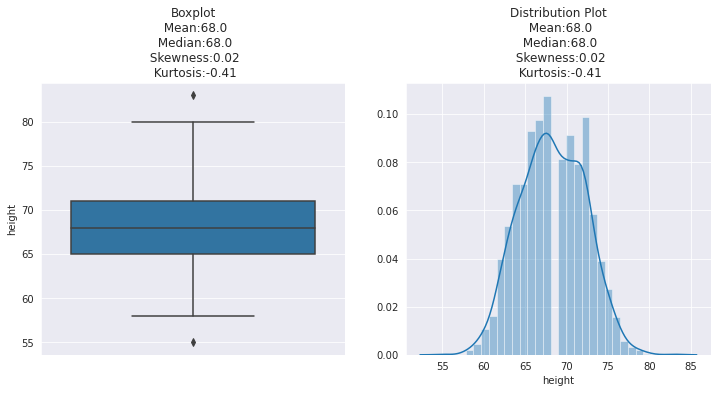

In [11]:
# Looking the distribution of column height
plt.figure(figsize=(12,5))

skewness = round(df.height.skew(),2)
kurtosis = round(df.height.kurtosis(),2)
mean = round(np.mean(df.height),0)
median = np.median(df.height)

plt.subplot(1,2,1)
sns.boxplot(y=df.height)
plt.title('Boxplot\n Mean:{}\n Median:{}\n Skewness:{}\n Kurtosis:{}'.format(mean,median,skewness,kurtosis))

plt.subplot(1,2,2)
sns.distplot(df.height)
plt.title('Distribution Plot\n Mean:{}\n Median:{}\n Skewness:{}\n Kurtosis:{}'.format(mean,median,skewness,kurtosis))

plt.show()

In [12]:
# creating a new column which stores height in feets
df['height_feet'] = round(df['height']*0.08333,1)

In [13]:
df.height_feet.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    2001.000000
mean        5.683658
std         0.326524
min         4.600000
25%         5.400000
50%         5.700000
75%         5.900000
90%         6.100000
95%         6.200000
99%         6.400000
max         6.900000
Name: height_feet, dtype: float64

In [14]:
# creating a column which has height in bins
df['height_bin'] = pd.cut(df.height_feet,bins=[4,5,6,7],labels=['4-5feets','5-6feets','6-7feets'],right=False)

In [15]:
# making a dummy variable for the height_bin column
heightd = pd.get_dummies(df.height_bin,prefix='height_')
df = pd.concat([df,heightd], axis=1)
df.drop(['height','height_feet','height_bin'],axis=1,inplace=True)

---
#### status

In [16]:
df.status.value_counts(normalize=True)

single            0.933033
available         0.032984
seeing someone    0.026987
married           0.006997
Name: status, dtype: float64

In [17]:
# 'single' and 'available' both have same context in dating site so just combine them
df['status'] = df['status'].replace('available','single')

In [18]:
# making a dummy variable for status
statusd = pd.get_dummies(df.status,prefix='status_')
df = pd.concat([df,statusd], axis=1)
df.drop('status',axis=1,inplace=True)

---
#### sex

In [19]:
df.sex.value_counts(normalize=True)

m    0.569215
f    0.430785
Name: sex, dtype: float64

In [20]:
# converting to numeric
df['sex'] = df['sex'].replace(('m','f'),(1,0))

---
#### orientation

In [21]:
df.orientation.value_counts(normalize=True)

straight    0.867566
gay         0.076462
bisexual    0.055972
Name: orientation, dtype: float64

In [22]:
# creating a new column and apply the logic to fill the values
df['looking_for'] = np.NaN

df[(df.orientation=='straight') & (df.sex==1)]['looking_for']='female'
df[(df.orientation=='straight') & (df.sex==0)]['looking_for']='male'

df[(df.orientation=='gay') & (df.sex==1)]['looking_for']='male'
df[(df.orientation=='gay') & (df.sex==0)]['looking_for']='female'

df[(df.orientation=='bisexual') & (df.sex==1)]['looking_for']='both'
df[(df.orientation=='bisexual') & (df.sex==0)]['looking_for']='both'

In [23]:
# dropping the column
df.drop('orientation',axis=1,inplace=True)

In [24]:
# making the dummy variables for looking_for column
lfd = pd.get_dummies(df.looking_for,prefix='looking_')
df = pd.concat([df,lfd], axis=1)
df.drop('looking_for',axis=1,inplace=True)

---
#### drinks

In [25]:
df.drinks.value_counts(normalize=True)

socially       0.696152
rarely         0.127936
often          0.083958
not at all     0.078461
very often     0.007996
desperately    0.005497
Name: drinks, dtype: float64

In [26]:
# making the dummy variables for drinks column
drinkd = pd.get_dummies(df.drinks,prefix='drink_')
df = pd.concat([df,drinkd], axis=1)
df.drop('drinks',axis=1,inplace=True)

---
#### drugs

In [27]:
df.drugs.value_counts(normalize=True)

never        0.792604
sometimes    0.198401
often        0.008996
Name: drugs, dtype: float64

In [28]:
# making the dummy variables for drugs column
drugd = pd.get_dummies(df.drugs,prefix='drug_')
df = pd.concat([df,drugd], axis=1)
df.drop('drugs',axis=1,inplace=True)

---
#### job

In [29]:
df.job.value_counts(normalize=True)

other                                0.142929
student                              0.112944
artistic / musical / writer          0.087956
science / tech / engineering         0.081459
medicine / health                    0.078961
computer / hardware / software       0.077961
sales / marketing / biz dev          0.077961
education / academia                 0.065467
executive / management               0.046477
banking / financial / real estate    0.039480
entertainment / media                0.038981
law / legal services                 0.026987
construction / craftsmanship         0.025987
hospitality / travel                 0.022989
clerical / administrative            0.016992
political / government               0.016492
transportation                       0.010995
retired                              0.008996
rather not say                       0.008496
unemployed                           0.007996
military                             0.003498
Name: job, dtype: float64

In [30]:
# as the count of last four jobs has less than 1%, so we just combine them into the 'other'
df['job'] = df['job'].replace(('retired','rather not say','unemployed','military'),
                             ('other','other','other','other'))

In [31]:
# making the dummy variables for job column
jd = pd.get_dummies(df.job,prefix='job_')
df = pd.concat([df,jd], axis=1)
df.drop('job',axis=1,inplace=True)

---
##### location

In [32]:
locn = df[['location']]
locn[['city','state']] = locn.location.str.split(',',expand=True)

In [33]:
locd = pd.get_dummies(locn.city,prefix='lives_in_')
locn = pd.concat([locn,locd], axis=1)

locn.head()

,location,city,state,lives_in__alameda,lives_in__albany,lives_in__atherton,lives_in__belmont,lives_in__belvedere tiburon,lives_in__benicia,lives_in__berkeley,lives_in__brisbane,lives_in__brooklyn,lives_in__burlingame,lives_in__canyon country,lives_in__castro valley,lives_in__cincinnati,lives_in__corte madera,lives_in__daly city,lives_in__el cerrito,lives_in__el sobrante,lives_in__emeryville,lives_in__fairfax,lives_in__foster city,lives_in__fremont,lives_in__green brae,lives_in__hacienda heights,lives_in__half moon bay,lives_in__hayward,lives_in__hercules,lives_in__lafayette,lives_in__lagunitas,lives_in__larkspur,lives_in__martinez,lives_in__menlo park,lives_in__mill valley,lives_in__millbrae,lives_in__montara,lives_in__moraga,lives_in__moss beach,lives_in__mountain view,lives_in__nha trang,lives_in__north hollywood,lives_in__novato,lives_in__oakland,lives_in__orinda,lives_in__pacifica,lives_in__palo alto,lives_in__petaluma,lives_in__phoenix,lives_in__pinole,lives_in__pleasant hill,lives_in__point richmond,lives_in__redwood city,lives_in__richmond,lives_in__rodeo,lives_in__san anselmo,lives_in__san bruno,lives_in__san carlos,lives_in__san francisco,lives_in__san leandro,lives_in__san lorenzo,lives_in__san mateo,lives_in__san pablo,lives_in__san rafael,lives_in__santa rosa,lives_in__sausalito,lives_in__south san francisco,lives_in__stanford,lives_in__stockton,lives_in__vallejo,lives_in__walnut creek,lives_in__woodacre,lives_in__woodside
0,"oakland, california",oakland,california,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"pleasant hill, california",pleasant hill,california,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"oakland, california",oakland,california,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"daly city, california",daly city,california,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"oakland, california",oakland,california,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
locn.iloc[:,3:].sum().sort_values(ascending=False).index

Index(['lives_in__san francisco', 'lives_in__oakland', 'lives_in__berkeley',
       'lives_in__san mateo', 'lives_in__palo alto', 'lives_in__alameda',
       'lives_in__san rafael', 'lives_in__san leandro',
       'lives_in__redwood city', 'lives_in__emeryville', 'lives_in__daly city',
       'lives_in__walnut creek', 'lives_in__hayward', 'lives_in__pacifica',
       'lives_in__el cerrito', 'lives_in__menlo park',
       'lives_in__mountain view', 'lives_in__richmond', 'lives_in__martinez',
       'lives_in__burlingame', 'lives_in__benicia', 'lives_in__vallejo',
       'lives_in__mill valley', 'lives_in__south san francisco',
       'lives_in__pleasant hill', 'lives_in__novato',
       'lives_in__castro valley', 'lives_in__lafayette',
       'lives_in__san carlos', 'lives_in__belmont', 'lives_in__san bruno',
       'lives_in__el sobrante', 'lives_in__millbrae', 'lives_in__fremont',
       'lives_in__half moon bay', 'lives_in__albany', 'lives_in__hercules',
       'lives_in__stanford', 

In [35]:
locn.iloc[:,3:].sum().sort_values(ascending=False).values

array([911, 250, 146,  56,  45,  35,  35,  33,  28,  27,  27,  24,  21,
        18,  17,  16,  15,  15,  15,  15,  15,  14,  14,  14,  13,  13,
        12,  11,   9,   9,   8,   8,   7,   7,   7,   6,   6,   6,   6,
         6,   5,   5,   5,   5,   5,   4,   3,   2,   2,   2,   2,   2,
         2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1])

Here we just looking for cities whose count is more than 20 and combine rest of the cities into the 'other' category

In [36]:
# rearranging the columns such that they appeared according to their count in descending order
locn = locn[['lives_in__san francisco', 'lives_in__oakland', 'lives_in__berkeley','lives_in__san mateo', 'lives_in__palo alto', 
             'lives_in__alameda','lives_in__san rafael', 'lives_in__san leandro','lives_in__redwood city', 
             'lives_in__emeryville', 'lives_in__daly city','lives_in__walnut creek', 'lives_in__hayward', 'lives_in__pacifica',
             'lives_in__el cerrito', 'lives_in__menlo park','lives_in__mountain view', 'lives_in__richmond', 
             'lives_in__martinez','lives_in__burlingame', 'lives_in__benicia', 'lives_in__vallejo','lives_in__mill valley', 
             'lives_in__south san francisco','lives_in__pleasant hill', 'lives_in__novato','lives_in__castro valley', 
             'lives_in__lafayette','lives_in__san carlos', 'lives_in__belmont', 'lives_in__san bruno','lives_in__el sobrante', 
             'lives_in__millbrae', 'lives_in__fremont','lives_in__half moon bay', 'lives_in__albany', 'lives_in__hercules',
             'lives_in__stanford', 'lives_in__san pablo', 'lives_in__san lorenzo','lives_in__fairfax', 'lives_in__atherton', 
             'lives_in__moraga','lives_in__sausalito', 'lives_in__san anselmo','lives_in__corte madera', 'lives_in__woodacre', 
             'lives_in__green brae','lives_in__belvedere tiburon', 'lives_in__rodeo', 'lives_in__orinda','lives_in__larkspur', 
             'lives_in__pinole', 'lives_in__canyon country','lives_in__stockton', 'lives_in__santa rosa', 'lives_in__brisbane',
             'lives_in__brooklyn', 'lives_in__point richmond', 'lives_in__lagunitas','lives_in__cincinnati', 'lives_in__phoenix',
             'lives_in__petaluma','lives_in__north hollywood', 'lives_in__nha trang','lives_in__foster city', 
             'lives_in__moss beach','lives_in__hacienda heights', 'lives_in__montara','lives_in__woodside']]

In [37]:
# creating a new column
locn['others'] = locn.iloc[:,13:].sum(axis=1).astype('int')

In [38]:
locn = locn[['lives_in__san francisco', 'lives_in__oakland', 'lives_in__berkeley','lives_in__san mateo', 'lives_in__palo alto', 
             'lives_in__alameda','lives_in__san rafael', 'lives_in__san leandro','lives_in__redwood city', 
             'lives_in__emeryville', 'lives_in__daly city','lives_in__walnut creek', 'lives_in__hayward','others', 
             'lives_in__pacifica','lives_in__el cerrito', 'lives_in__menlo park','lives_in__mountain view', 'lives_in__richmond', 
             'lives_in__martinez','lives_in__burlingame', 'lives_in__benicia', 'lives_in__vallejo','lives_in__mill valley', 
             'lives_in__south san francisco','lives_in__pleasant hill', 'lives_in__novato','lives_in__castro valley', 
             'lives_in__lafayette','lives_in__san carlos', 'lives_in__belmont', 'lives_in__san bruno','lives_in__el sobrante', 
             'lives_in__millbrae', 'lives_in__fremont','lives_in__half moon bay', 'lives_in__albany', 'lives_in__hercules',
             'lives_in__stanford', 'lives_in__san pablo', 'lives_in__san lorenzo','lives_in__fairfax', 'lives_in__atherton', 
             'lives_in__moraga','lives_in__sausalito', 'lives_in__san anselmo','lives_in__corte madera', 'lives_in__woodacre', 
             'lives_in__green brae','lives_in__belvedere tiburon', 'lives_in__rodeo', 'lives_in__orinda','lives_in__larkspur', 
             'lives_in__pinole', 'lives_in__canyon country','lives_in__stockton', 'lives_in__santa rosa', 'lives_in__brisbane',
             'lives_in__brooklyn', 'lives_in__point richmond', 'lives_in__lagunitas','lives_in__cincinnati', 'lives_in__phoenix',
             'lives_in__petaluma','lives_in__north hollywood', 'lives_in__nha trang','lives_in__foster city', 
             'lives_in__moss beach','lives_in__hacienda heights', 'lives_in__montara','lives_in__woodside']]

In [39]:
# storing only those columns whose count is greater than 20 and plus one extra column 'other'
locn = locn.iloc[:,:14]

In [40]:
# concatinate the main df with this location df
df = pd.concat([df,locn],axis=1)

# dropping the column
df.drop('location',axis=1,inplace=True)

---
#### pets

In [41]:
df.pets.value_counts(normalize=True)

likes dogs and likes cats          0.371314
likes dogs                         0.151424
likes dogs and has cats            0.114443
has dogs                           0.091954
has dogs and likes cats            0.073963
likes dogs and dislikes cats       0.060470
has dogs and has cats              0.043478
has cats                           0.031484
likes cats                         0.029485
has dogs and dislikes cats         0.011994
dislikes dogs and dislikes cats    0.008496
dislikes dogs and likes cats       0.004498
dislikes cats                      0.002499
dislikes dogs                      0.002499
dislikes dogs and has cats         0.001999
Name: pets, dtype: float64

In [42]:
# creating a fuction that return whether user likes cats or dogs or both or none
def pet_like(txt):
    if txt.find('likes dogs and likes cats')!= -1:
        return 'dog and cat'
    elif txt.find('likes dogs')!= -1:
        return 'dog'
    elif txt.find('likes cats')!= -1:
        return 'cat'
    else:
        return 'none'

# calling the above function
df['pet_like'] = df['pets'].apply(lambda x: pet_like(x))

In [43]:
# creating a function that returns whether a person owned cats or dogs or both or none
def pet_owned(txt):
    if txt.find('has dogs and has cats')!= -1:
        return 'dog and cat'
    elif txt.find('has dogs')!= -1:
        return 'dog'
    elif txt.find('has cats')!= -1:
        return 'cat'
    else:
        return 'none'

# calling the function
df['pet_owned'] = df['pets'].apply(lambda x: pet_owned(x))

In [44]:
# making the dummy variables for pet_like column
petld = pd.get_dummies(df.pet_like,prefix='petLike_')
df = pd.concat([df,petld], axis=1)
df.drop('pet_like',axis=1,inplace=True)

In [45]:
# making the dummy variables for pet_owned column
petod = pd.get_dummies(df.pet_owned,prefix='petOwn_')
df = pd.concat([df,petod], axis=1)
df.drop('pet_owned',axis=1,inplace=True)

In [46]:
# dropping the variable
df.drop('pets',axis=1,inplace=True)

---
#### smokes

In [47]:
df.smokes.value_counts(normalize=True)

no                0.814593
sometimes         0.063968
yes               0.046977
when drinking     0.045477
trying to quit    0.028986
Name: smokes, dtype: float64

In [48]:
# combining the categories as they have similar context
df['smokes'] = df['smokes'].replace('trying to quit','sometimes')
df['smokes'] = df['smokes'].replace('when drinking','sometimes')

In [49]:
# making the dummy variables for smokes column
smoked = pd.get_dummies(df.smokes,prefix='smoke_')
df = pd.concat([df,smoked], axis=1)
df.drop('smokes',axis=1,inplace=True)

---
#### new language

In [50]:
df.new_languages.value_counts(normalize=True)

not interested         0.524738
interested             0.316342
somewhat interested    0.158921
Name: new_languages, dtype: float64

In [51]:
# dropping the variable as it has no relevancy
nld = pd.get_dummies(df.new_languages,prefix='new_lang_')
df = pd.concat([df,nld], axis=1)
df.drop('new_languages',axis=1,inplace=True)

---
#### body profile

In [52]:
df.body_profile.value_counts(normalize=True)

average           0.278361
fit               0.216392
athletic          0.192404
curvy             0.089455
thin              0.080460
a little extra    0.054973
skinny            0.032484
full figured      0.021489
overweight        0.012494
used up           0.009995
jacked            0.006497
rather not say    0.004998
Name: body_profile, dtype: float64

In [53]:
# making the dummy variables for body_profile column
bd = pd.get_dummies(df.body_profile,prefix='body_')
df = pd.concat([df,bd], axis=1)
df.drop('body_profile',axis=1,inplace=True)

---
#### education level

In [54]:
df.education_level.value_counts(normalize=True)

3.0    0.502249
2.0    0.238381
4.0    0.203898
1.0    0.035982
5.0    0.019490
Name: education_level, dtype: float64

In [55]:
# using scaler to convert them between 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['education_level'] = scaler.fit_transform(df[['education_level']])

---
#### dropped out

In [56]:
df.dropped_out.value_counts(normalize=True)

no     0.948526
yes    0.051474
Name: dropped_out, dtype: float64

In [57]:
# converting to numeric
df['dropped_out'] = df['dropped_out'].replace(('no','yes'),(0,1))

---
#### interests and other_interests

In [58]:
df.interests.value_counts(normalize=True)

music                0.077461
politics             0.052474
reading              0.052474
singing              0.050475
photography          0.045977
instruments          0.043978
video games          0.043478
sports               0.041479
painting             0.041479
movies               0.039480
dancing              0.037481
travelling           0.036982
cooking              0.033483
designing            0.031984
craft                0.031984
sketching            0.031984
food                 0.029985
diy                  0.024488
gardening            0.023988
writting             0.023488
studying             0.023488
yoga                 0.022989
social_networking    0.022989
organising events    0.021489
makeup               0.020990
acting               0.020490
astronomy            0.018491
calligraphy          0.016492
fishing              0.016492
collectibles         0.013493
camping              0.007996
Name: interests, dtype: float64

In [59]:
df.other_interests.value_counts(normalize=True)

music                0.078961
sports               0.050975
reading              0.049975
photography          0.049975
singing              0.048976
politics             0.046977
video games          0.044978
dancing              0.043978
painting             0.042479
movies               0.040480
craft                0.038981
instruments          0.035982
sketching            0.033483
travelling           0.030985
designing            0.030485
makeup               0.028486
social_networking    0.028486
food                 0.026987
diy                  0.026487
writting             0.024988
cooking              0.024488
gardening            0.024488
acting               0.022489
fishing              0.018991
studying             0.017991
astronomy            0.017491
yoga                 0.017491
organising events    0.016992
calligraphy          0.016492
collectibles         0.010495
camping              0.009495
Name: other_interests, dtype: float64

In [60]:
# making the set of all the interest from both the columns and taking union of that so that there is no repetation
s1 = set(df.interests.value_counts(normalize=True).index)
s2 = set(df.other_interests.value_counts(normalize=True).index)
s3 = s1.union(s2)

In [61]:
# creating a new columns by combining the two interests columns
df['hobbies'] = df['interests']+','+df['other_interests']

In [62]:
# creating new columns of hobbies as a dummy variable
for col in list(s3):
    df[col] = df.hobbies.str.find(col).apply(lambda x: 0 if x==-1 else 1)

In [63]:
df.drop(['interests','other_interests','hobbies'],axis=1,inplace=True)

---
#### location preference

In [64]:
df.location_preference.value_counts(normalize=True)

same city     0.584208
same state    0.247376
anywhere      0.168416
Name: location_preference, dtype: float64

In [65]:
# making the dummy variables for location_preference column
locd = pd.get_dummies(df.location_preference,prefix='location_pref_')
df = pd.concat([df,locd], axis=1)
df.drop('location_preference',axis=1,inplace=True)

---
#### language

In [66]:
# copying the language column in other object
lang = df[['language']]

# splitting the column
lang[['L1','L2','L3','L4','L5']] = lang.language.str.split(',',expand=True)

lang.head(10)

,language,L1,L2,L3,L4,L5
0,"english (fluently), spanish (poorly), sign lan...",english (fluently),spanish (poorly),sign language (poorly),None,None
1,"english (fluently), tagalog (okay), french (po...",english (fluently),tagalog (okay),french (poorly),None,None
2,"english (fluently), sign language (poorly), fr...",english (fluently),sign language (poorly),french (poorly),italian (poorly),None
3,english,english,None,None,None,None
4,english,english,None,None,None,None
5,english (fluently),english (fluently),None,None,None,None
6,english (fluently),english (fluently),None,None,None,None
7,english (fluently),english (fluently),None,None,None,None
8,"english (fluently), spanish (okay)",english (fluently),spanish (okay),None,None,None
9,"english, french, german, chinese, sign language",english,french,german,chinese,sign language


In [67]:
# looking for null entries
lang.isnull().sum()

language       0
L1             0
L2           856
L3          1475
L4          1799
L5          1915
dtype: int64

In [68]:
# replacing the null values with 'none'
lang['L2'] = lang['L2'].replace(np.NaN, 'None')
lang['L3'] = lang['L3'].replace(np.NaN, 'None')
lang['L4'] = lang['L4'].replace(np.NaN, 'None')
lang['L5'] = lang['L5'].replace(np.NaN, 'None')

In [69]:
# creating a function that returns the language that user marked as fluent he/she is in
def fluent(txt):
    l1 = list(txt)
    l2 = list(txt.str.contains('(fluently)'))
    l3 = []
    for i,j in enumerate(l2):
        if j==True:
            l3.append(l1[i])
        else:
            l3.append('None')
    return l3

In [70]:
# calling the above function on all the five columns
lang['F1'] = fluent(lang['L1'])
lang['F2'] = fluent(lang['L2'])
lang['F3'] = fluent(lang['L3'])
lang['F4'] = fluent(lang['L4'])
lang['F5'] = fluent(lang['L5'])

In [71]:
lang.head()

,language,L1,L2,L3,L4,L5,F1,F2,F3,F4,F5
0,"english (fluently), spanish (poorly), sign lan...",english (fluently),spanish (poorly),sign language (poorly),None,None,english (fluently),None,None,None,None
1,"english (fluently), tagalog (okay), french (po...",english (fluently),tagalog (okay),french (poorly),None,None,english (fluently),None,None,None,None
2,"english (fluently), sign language (poorly), fr...",english (fluently),sign language (poorly),french (poorly),italian (poorly),None,english (fluently),None,None,None,None
3,english,english,None,None,None,None,None,None,None,None,None
4,english,english,None,None,None,None,None,None,None,None,None


In [72]:
lang.isnull().sum()

language    0
L1          0
L2          0
L3          0
L4          0
L5          0
F1          0
F2          0
F3          0
F4          0
F5          0
dtype: int64

In [73]:
# removing any extra white spaces
lang['F1'] = lang['F1'].str.strip()
lang['F2'] = lang['F2'].str.strip()
lang['F3'] = lang['F3'].str.strip()
lang['F4'] = lang['F4'].str.strip()
lang['F5'] = lang['F5'].str.strip()

In [74]:
# creating the sets
f1 = set(lang.F1.unique())
f2 = set(lang.F2.unique())
f3 = set(lang.F3.unique())
f4 = set(lang.F4.unique())
f5 = set(lang.F5.unique())

In [75]:
# getting all the unique languages from all these columns
u1 = f1.union(f2)
u2 = u1.union(f3)
u3 = u2.union(f4)
u4 = u3.union(f5)

In [76]:
lang.head()

,language,L1,L2,L3,L4,L5,F1,F2,F3,F4,F5
0,"english (fluently), spanish (poorly), sign lan...",english (fluently),spanish (poorly),sign language (poorly),None,None,english (fluently),None,None,None,None
1,"english (fluently), tagalog (okay), french (po...",english (fluently),tagalog (okay),french (poorly),None,None,english (fluently),None,None,None,None
2,"english (fluently), sign language (poorly), fr...",english (fluently),sign language (poorly),french (poorly),italian (poorly),None,english (fluently),None,None,None,None
3,english,english,None,None,None,None,None,None,None,None,None
4,english,english,None,None,None,None,None,None,None,None,None


In [77]:
# creating the columns
for col in list(u4):
    lang[col] = lang.language.str.find(col).apply(lambda x: 0 if x==-1 else 1)

In [78]:
# creating a column which gives number of languages a user know
lang['lang_known'] = lang['language'].apply(lambda x:len(x.split(',')))

In [79]:
lang.sample(10)

,language,L1,L2,L3,L4,L5,F1,F2,F3,F4,F5,ukrainian (fluently),lisp (fluently),greek (fluently),None,gujarati (fluently),russian (fluently),irish (fluently),swedish (fluently),slovak (fluently),czech (fluently),french (fluently),other (fluently),esperanto (fluently),dutch (fluently),ilongo (fluently),bulgarian (fluently),danish (fluently),indonesian (fluently),tamil (fluently),bengali (fluently),afrikaans (fluently),portuguese (fluently),icelandic (fluently),english (fluently),c++ (fluently),german (fluently),korean (fluently),italian (fluently),cebuano (fluently),ancient greek (fluently),chinese (fluently),maori (fluently),latin (fluently),sign language (fluently),spanish (fluently),sanskrit (fluently),farsi (fluently),japanese (fluently),tagalog (fluently),hebrew (fluently),hungarian (fluently),hindi (fluently),polish (fluently),thai (fluently),urdu (fluently),arabic (fluently),turkish (fluently),vietnamese (fluently),norwegian (fluently),lang_known
1531,"english (fluently), spanish (poorly)",english (fluently),spanish (poorly),None,None,None,english (fluently),None,None,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1362,"english (fluently), japanese (okay), chinese (...",english (fluently),japanese (okay),chinese (okay),spanish (poorly),None,english (fluently),None,None,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
1691,english,english,None,None,None,None,None,None,None,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
793,"english (fluently), spanish (okay)",english (fluently),spanish (okay),None,None,None,english (fluently),None,None,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1718,"english, farsi",english,farsi,None,None,None,None,None,None,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
475,"english, spanish (okay)",english,spanish (okay),None,None,None,None,None,None,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1446,"english, bengali, spanish",english,bengali,spanish,None,None,None,None,None,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1583,"english (poorly), hawaiian (okay)",english (poorly),hawaiian (okay),None,None,None,None,None,None,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1076,"english (fluently), chinese (okay), spanish (o...",english (fluently),chinese (okay),spanish (okay),None,None,english (fluently),None,None,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1003,"english (poorly), other (fluently)",english (poorly),other (fluently),None,None,None,None,other (fluently),None,None,None,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [80]:
# keeping only relevant columns
lang = lang.iloc[:,11:]

In [81]:
lang.sum(axis=0).sort_values(ascending=False)

lang_known                  3960
english (fluently)          1173
spanish (fluently)           110
chinese (fluently)            36
french (fluently)             35
german (fluently)             27
c++ (fluently)                24
other (fluently)              19
italian (fluently)            13
hindi (fluently)              12
hebrew (fluently)              9
tagalog (fluently)             9
farsi (fluently)               9
portuguese (fluently)          8
sign language (fluently)       8
russian (fluently)             8
japanese (fluently)            7
korean (fluently)              7
swedish (fluently)             5
thai (fluently)                4
arabic (fluently)              4
greek (fluently)               4
slovak (fluently)              3
vietnamese (fluently)          3
bengali (fluently)             3
lisp (fluently)                3
afrikaans (fluently)           3
czech (fluently)               2
esperanto (fluently)           2
indonesian (fluently)          2
polish (fl

In [82]:
# dropping the language
lang.drop('c++ (fluently)',axis=1,inplace=True)

In [83]:
# arranging the columns in the order of their counts
lang = lang[['lang_known','english (fluently)','spanish (fluently)','chinese (fluently)','french (fluently)',
             'german (fluently)','italian (fluently)','farsi (fluently)','hindi (fluently)','russian (fluently)',
             'hebrew (fluently)','tagalog (fluently)','japanese (fluently)', 'sign language (fluently)','portuguese (fluently)',
             'swedish (fluently)','korean (fluently)','sanskrit (fluently)', 'dutch (fluently)', 'arabic (fluently)', 
             'hungarian (fluently)', 'icelandic (fluently)','gujarati (fluently)','irish (fluently)', 'vietnamese (fluently)',
             'esperanto (fluently)', 'tamil (fluently)', 'bulgarian (fluently)', 'indonesian (fluently)','norwegian (fluently)',
             'thai (fluently)', 'urdu (fluently)', 'ukrainian (fluently)','cebuano (fluently)', 'polish (fluently)', 
             'bengali (fluently)','ancient greek (fluently)', 'slovak (fluently)', 'None','afrikaans (fluently)', 
             'maori (fluently)', 'czech (fluently)','danish (fluently)', 'latin (fluently)', 'other (fluently)',
             'ilongo (fluently)', 'greek (fluently)', 'lisp (fluently)','turkish (fluently)']]

In [84]:
# keeping those languages whose count is greater than 5 and combine rest other into one single column
lang['others'] = lang.iloc[:,17:].sum(axis=1)

In [85]:
lang.head()

,lang_known,english (fluently),spanish (fluently),chinese (fluently),french (fluently),german (fluently),italian (fluently),farsi (fluently),hindi (fluently),russian (fluently),hebrew (fluently),tagalog (fluently),japanese (fluently),sign language (fluently),portuguese (fluently),swedish (fluently),korean (fluently),sanskrit (fluently),dutch (fluently),arabic (fluently),hungarian (fluently),icelandic (fluently),gujarati (fluently),irish (fluently),vietnamese (fluently),esperanto (fluently),tamil (fluently),bulgarian (fluently),indonesian (fluently),norwegian (fluently),thai (fluently),urdu (fluently),ukrainian (fluently),cebuano (fluently),polish (fluently),bengali (fluently),ancient greek (fluently),slovak (fluently),None,afrikaans (fluently),maori (fluently),czech (fluently),danish (fluently),latin (fluently),other (fluently),ilongo (fluently),greek (fluently),lisp (fluently),turkish (fluently),others
0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [86]:
# rearranging of columns
lang = lang[['lang_known','english (fluently)','spanish (fluently)','chinese (fluently)','french (fluently)',
             'german (fluently)','italian (fluently)','farsi (fluently)','hindi (fluently)','russian (fluently)',
             'hebrew (fluently)','tagalog (fluently)','japanese (fluently)', 'sign language (fluently)','portuguese (fluently)',
             'swedish (fluently)','korean (fluently)','others','sanskrit (fluently)', 'dutch (fluently)', 'arabic (fluently)', 
             'hungarian (fluently)', 'icelandic (fluently)','gujarati (fluently)','irish (fluently)', 'vietnamese (fluently)',
             'esperanto (fluently)', 'tamil (fluently)', 'bulgarian (fluently)', 'indonesian (fluently)','norwegian (fluently)',
             'thai (fluently)', 'urdu (fluently)', 'ukrainian (fluently)','cebuano (fluently)', 'polish (fluently)', 
             'bengali (fluently)','ancient greek (fluently)', 'slovak (fluently)', 'None','afrikaans (fluently)', 
             'maori (fluently)', 'czech (fluently)','danish (fluently)', 'latin (fluently)', 'other (fluently)',
             'ilongo (fluently)', 'greek (fluently)', 'lisp (fluently)','turkish (fluently)']]

In [87]:
# keeping only relevant languages
lang = lang.iloc[:,:18]
lang.head()

,lang_known,english (fluently),spanish (fluently),chinese (fluently),french (fluently),german (fluently),italian (fluently),farsi (fluently),hindi (fluently),russian (fluently),hebrew (fluently),tagalog (fluently),japanese (fluently),sign language (fluently),portuguese (fluently),swedish (fluently),korean (fluently),others
0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [88]:
# concate the lang_fluent and lang_known to the main dataframe
df = pd.concat([df,lang],axis=1)

In [89]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['lang_known'] = scaler.fit_transform(df[['lang_known']])
df.drop('language',axis=1,inplace=True)

---
#### bio

For this column we have use **text mining** technique and finally use TF-IDF matrix

In [90]:
bio = df[['bio']]
bio.head()

,bio
0,bottom line i love life! i work hard and i lov...
1,"i'm a straightforward, genuine, fun loving (i'..."
2,mmmmm yummy tacosss. yoga is where it's at. i ...
3,i'm a stealth geek. that special mix of techni...
4,with the whisper of the wind i was weaved into...


In [91]:
# converting all words to lowercase

bio['bio'] = bio['bio'].str.lower()

In [92]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}


def contraction(txt):
    l1 = list(txt)
    l2 = []
    for i in l1:
        l2.append(' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in i.split(" ")]))
    return l2


bio['bio_clean']= contraction(bio['bio'])

In [93]:
# creating a function that removes "'s" part from the words
def removing_s(txt):
    l1 = list(txt)
    l2 = []
    for i in l1:
        l2.append(re.sub(r"'s\b","",i))
    return l2

bio['bio_clean']= removing_s(bio['bio_clean'])

In [94]:
# function that keep only letters and remove other things
def only_letters(txt):
    l1 = list(txt)
    l2 = []
    for i in l1:
        l2.append(re.sub("[^a-zA-Z]", " ", i))
    return l2

bio['bio_clean']= only_letters(bio['bio_clean'])

In [95]:
# function that removes puctuations

import string
string.punctuation

def remove_punctuation(txt):
    txt_nopunct = "".join([c for c in txt if c not in string.punctuation])
    return txt_nopunct

bio['bio_clean_rp'] = bio['bio_clean'].apply(lambda x: remove_punctuation(x))
bio.head()

,bio,bio_clean,bio_clean_rp
0,bottom line i love life! i work hard and i lov...,bottom line i love life i work hard and i lov...,bottom line i love life i work hard and i lov...
1,"i'm a straightforward, genuine, fun loving (i'...",i am a straightforward genuine fun loving i...,i am a straightforward genuine fun loving i...
2,mmmmm yummy tacosss. yoga is where it's at. i ...,mmmmm yummy tacosss yoga is where it is at i...,mmmmm yummy tacosss yoga is where it is at i...
3,i'm a stealth geek. that special mix of techni...,i am a stealth geek that special mix of techn...,i am a stealth geek that special mix of techn...
4,with the whisper of the wind i was weaved into...,with the whisper of the wind i was weaved into...,with the whisper of the wind i was weaved into...


In [96]:
# function for tokenization

import re
from nltk.tokenize import word_tokenize

def tokenize(txt):
    token = re.split('\W+', txt)
    return token

bio['bio_clean_tokenize'] = bio['bio_clean_rp'].apply(lambda x: tokenize(x))

# another way
# df['msg_clean_tokenize'] = df['msg_clean'].apply(word_tokenize)
# df['msg_clean_tokenize'] = df['msg_clean'].apply(lambda x: x.split())

bio.head()

,bio,bio_clean,bio_clean_rp,bio_clean_tokenize
0,bottom line i love life! i work hard and i lov...,bottom line i love life i work hard and i lov...,bottom line i love life i work hard and i lov...,"[bottom, line, i, love, life, i, work, hard, a..."
1,"i'm a straightforward, genuine, fun loving (i'...",i am a straightforward genuine fun loving i...,i am a straightforward genuine fun loving i...,"[i, am, a, straightforward, genuine, fun, lovi..."
2,mmmmm yummy tacosss. yoga is where it's at. i ...,mmmmm yummy tacosss yoga is where it is at i...,mmmmm yummy tacosss yoga is where it is at i...,"[mmmmm, yummy, tacosss, yoga, is, where, it, i..."
3,i'm a stealth geek. that special mix of techni...,i am a stealth geek that special mix of techn...,i am a stealth geek that special mix of techn...,"[i, am, a, stealth, geek, that, special, mix, ..."
4,with the whisper of the wind i was weaved into...,with the whisper of the wind i was weaved into...,with the whisper of the wind i was weaved into...,"[with, the, whisper, of, the, wind, i, was, we..."


In [97]:
# function for removing stopwords

stopwords = nltk.corpus.stopwords.words('english')

# list of stopwords
# print(stopwords[:30])

def remove_stopwords(txt):
    txt_clean = [word for word in txt if word not in stopwords]
    return txt_clean

bio['bio_no_sw'] = bio['bio_clean_tokenize'].apply(lambda x: remove_stopwords(x))
bio.head()

,bio,bio_clean,bio_clean_rp,bio_clean_tokenize,bio_no_sw
0,bottom line i love life! i work hard and i lov...,bottom line i love life i work hard and i lov...,bottom line i love life i work hard and i lov...,"[bottom, line, i, love, life, i, work, hard, a...","[bottom, line, love, life, work, hard, love, h..."
1,"i'm a straightforward, genuine, fun loving (i'...",i am a straightforward genuine fun loving i...,i am a straightforward genuine fun loving i...,"[i, am, a, straightforward, genuine, fun, lovi...","[straightforward, genuine, fun, loving, seriou..."
2,mmmmm yummy tacosss. yoga is where it's at. i ...,mmmmm yummy tacosss yoga is where it is at i...,mmmmm yummy tacosss yoga is where it is at i...,"[mmmmm, yummy, tacosss, yoga, is, where, it, i...","[mmmmm, yummy, tacosss, yoga, love, life, part..."
3,i'm a stealth geek. that special mix of techni...,i am a stealth geek that special mix of techn...,i am a stealth geek that special mix of techn...,"[i, am, a, stealth, geek, that, special, mix, ...","[stealth, geek, special, mix, technical, obses..."
4,with the whisper of the wind i was weaved into...,with the whisper of the wind i was weaved into...,with the whisper of the wind i was weaved into...,"[with, the, whisper, of, the, wind, i, was, we...","[whisper, wind, weaved, curls, crashing, waves..."


In [98]:
# function for lemmatization
wn = nltk.WordNetLemmatizer()

def lemmatizing(txt):
    text = [wn.lemmatize(word) for word in txt]
    return text

bio['bio_lemmatize'] = bio['bio_no_sw'].apply(lambda x: lemmatizing(x))
bio.head()

,bio,bio_clean,bio_clean_rp,bio_clean_tokenize,bio_no_sw,bio_lemmatize
0,bottom line i love life! i work hard and i lov...,bottom line i love life i work hard and i lov...,bottom line i love life i work hard and i lov...,"[bottom, line, i, love, life, i, work, hard, a...","[bottom, line, love, life, work, hard, love, h...","[bottom, line, love, life, work, hard, love, h..."
1,"i'm a straightforward, genuine, fun loving (i'...",i am a straightforward genuine fun loving i...,i am a straightforward genuine fun loving i...,"[i, am, a, straightforward, genuine, fun, lovi...","[straightforward, genuine, fun, loving, seriou...","[straightforward, genuine, fun, loving, seriou..."
2,mmmmm yummy tacosss. yoga is where it's at. i ...,mmmmm yummy tacosss yoga is where it is at i...,mmmmm yummy tacosss yoga is where it is at i...,"[mmmmm, yummy, tacosss, yoga, is, where, it, i...","[mmmmm, yummy, tacosss, yoga, love, life, part...","[mmmmm, yummy, taco, yoga, love, life, part, c..."
3,i'm a stealth geek. that special mix of techni...,i am a stealth geek that special mix of techn...,i am a stealth geek that special mix of techn...,"[i, am, a, stealth, geek, that, special, mix, ...","[stealth, geek, special, mix, technical, obses...","[stealth, geek, special, mix, technical, obses..."
4,with the whisper of the wind i was weaved into...,with the whisper of the wind i was weaved into...,with the whisper of the wind i was weaved into...,"[with, the, whisper, of, the, wind, i, was, we...","[whisper, wind, weaved, curls, crashing, waves...","[whisper, wind, weaved, curl, crashing, wave, ..."


In [99]:
#bio['length_before'] = bio['bio'].apply(lambda x:len(x.split(' ')))
#bio['length_after'] = bio['bio_lemmatize'].apply(lambda x:len(x))

In [100]:
# joined all the clean words back to the sentences
bio['final'] = bio['bio_lemmatize'].apply(lambda x:" ".join(x))

In [101]:
# creating a function for scoring the sentiment of the sentence
# x<0 - Negative
# x=0 - Neutral
# x>0 & x<=1 - Positive

def sentiment(txt):
    return (TextBlob(txt).sentiment.polarity)

bio['sentiment_score'] = bio['bio'].apply(lambda x: sentiment(x))

# replacing all the negative values to 0
bio['sentiment_score'] = bio['sentiment_score'].apply(lambda x: 0 if x<0 else x)

In [102]:
bio.head()

,bio,bio_clean,bio_clean_rp,bio_clean_tokenize,bio_no_sw,bio_lemmatize,final,sentiment_score
0,bottom line i love life! i work hard and i lov...,bottom line i love life i work hard and i lov...,bottom line i love life i work hard and i lov...,"[bottom, line, i, love, life, i, work, hard, a...","[bottom, line, love, life, work, hard, love, h...","[bottom, line, love, life, work, hard, love, h...",bottom line love life work hard love hard eart...,0.214354
1,"i'm a straightforward, genuine, fun loving (i'...",i am a straightforward genuine fun loving i...,i am a straightforward genuine fun loving i...,"[i, am, a, straightforward, genuine, fun, lovi...","[straightforward, genuine, fun, loving, seriou...","[straightforward, genuine, fun, loving, seriou...",straightforward genuine fun loving serious pro...,0.234283
2,mmmmm yummy tacosss. yoga is where it's at. i ...,mmmmm yummy tacosss yoga is where it is at i...,mmmmm yummy tacosss yoga is where it is at i...,"[mmmmm, yummy, tacosss, yoga, is, where, it, i...","[mmmmm, yummy, tacosss, yoga, love, life, part...","[mmmmm, yummy, taco, yoga, love, life, part, c...",mmmmm yummy taco yoga love life part content p...,0.274019
3,i'm a stealth geek. that special mix of techni...,i am a stealth geek that special mix of techn...,i am a stealth geek that special mix of techn...,"[i, am, a, stealth, geek, that, special, mix, ...","[stealth, geek, special, mix, technical, obses...","[stealth, geek, special, mix, technical, obses...",stealth geek special mix technical obsession e...,0.117687
4,with the whisper of the wind i was weaved into...,with the whisper of the wind i was weaved into...,with the whisper of the wind i was weaved into...,"[with, the, whisper, of, the, wind, i, was, we...","[whisper, wind, weaved, curls, crashing, waves...","[whisper, wind, weaved, curl, crashing, wave, ...",whisper wind weaved curl crashing wave tide sp...,0.300000


In [103]:
# function that removes words whose length less than 3
def lessthan3(txt):
    l1 = list(txt.strip().split(' '))
    l2 = []
    for i in l1:
        if len(i)>3:
            l2.append(i)
    return(" ".join(l2))

bio['final1'] = bio['final'].apply(lambda x:lessthan3(x))

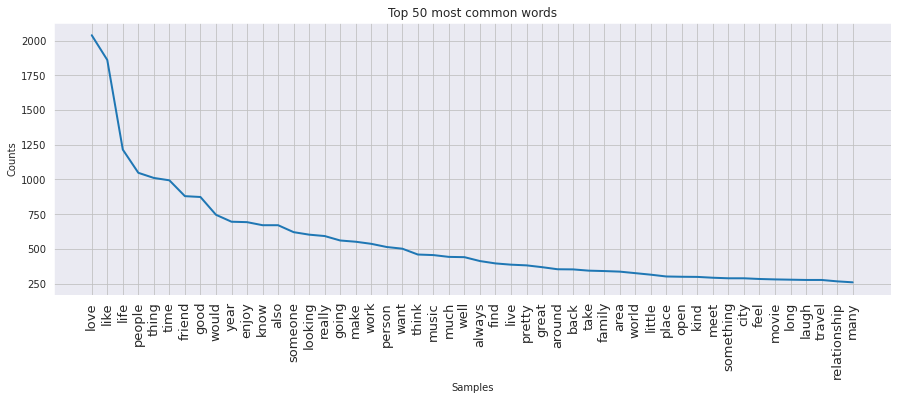

In [104]:
# graph showing top 50 words used by the users
all_words = []
for line in list(bio['final1']):
    words = line.split()
    for word in words:
        all_words.append(word)
        
plt.figure(figsize=(15,5))
plt.title('Top 50 most common words')
plt.xticks(fontsize=13)
fd = nltk.FreqDist(all_words)
fd.plot(50,cumulative=False)
plt.show()

In [105]:
# keeping only relevant columns
bio_final = bio[['final1','sentiment_score']]

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer

# creating a TF-IDF matrix with 1000 words
tfidf = TfidfVectorizer(max_features=1000)

X = tfidf.fit_transform(bio_final['final1'])
print(X.shape)

(2001, 1000)


In [107]:
# converting it into dataframe
bio_tfidf = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names())
bio_tfidf.head()

,ability,able,abroad,absolutely,accent,across,action,active,activity,actually,admit,adore,adult,adventure,adventurous,affectionate,afraid,alive,almost,alone,along,alot,already,also,although,always,amazing,ambitious,america,american,amount,animal,anime,another,answer,anyone,anything,anyway,anywhere,appreciate,area,around,artist,artistic,asian,aspect,athletic,attention,attitude,attracted,...,wanted,warm,watch,watching,water,wear,weather,week,weekend,weird,welcome,well,went,west,whatever,whenever,whether,white,whole,wide,wild,willing,wine,winter,wish,within,without,witty,woman,wonder,wonderful,wood,word,work,worked,worker,working,world,worth,would,write,writer,writing,wrong,yeah,year,yoga,york,young,younger
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.115956,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.247145,0.0,0.0,0.0,0.0,0.091542,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065580,0.070728,0.0,0.0,0.0,0.0,0.0,0.0,0.091118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042929,0.0,0.0,0.0,0.0,0.0,0.092865,0.00000,0.0,0.0,0.079101,0.0,0.075541,0.057997,0.0,0.0,0.0,0.051833,0.0522,0.0,0.0,0.202651,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.134463,0.0,0.084299,0.0,0.0,0.0,0.0,0.0,0.048680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061806,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.128531,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.18449,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.357166,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.095407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.089736,0.0,0.0,0.0,0.209898,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.148053,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.334713,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [108]:
# concat the TF-IDF and sentiment_score to the main dataframe
df = pd.concat([df,bio_tfidf,bio_final[['sentiment_score']]],axis=1)

df.drop('bio',axis=1,inplace=True)

In [109]:
df.head()

,user_id,sex,education_level,dropped_out,age__17-24,age__25-30,age__31-40,age__41-50,age__50+,height__4-5feets,height__5-6feets,height__6-7feets,status__married,status__seeing someone,status__single,drink__desperately,drink__not at all,drink__often,drink__rarely,drink__socially,drink__very often,drug__never,drug__often,drug__sometimes,job__artistic / musical / writer,job__banking / financial / real estate,job__clerical / administrative,job__computer / hardware / software,job__construction / craftsmanship,job__education / academia,job__entertainment / media,job__executive / management,job__hospitality / travel,job__law / legal services,job__medicine / health,job__other,job__political / government,job__sales / marketing / biz dev,job__science / tech / engineering,job__student,job__transportation,lives_in__san francisco,lives_in__oakland,lives_in__berkeley,lives_in__san mateo,lives_in__palo alto,lives_in__alameda,lives_in__san rafael,lives_in__san leandro,lives_in__redwood city,...,warm,watch,watching,water,wear,weather,week,weekend,weird,welcome,well,went,west,whatever,whenever,whether,white,whole,wide,wild,willing,wine,winter,wish,within,without,witty,woman,wonder,wonderful,wood,word,work,worked,worker,working,world,worth,would,write,writer,writing,wrong,yeah,year,yoga,york,young,younger,sentiment_score
0,fffe3100,0,0.75,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.247145,0.0,0.0,0.0,0.0,0.091542,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.214354
1,fffe3200,1,0.50,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.134463,0.0,0.084299,0.0,0.0,0.0,0.0,0.0,0.048680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061806,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.234283
2,fffe3300,0,0.25,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.095407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.089736,0.0,0.0,0.0,0.209898,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.148053,0.0,0.0,0.0,0.274019
3,fffe3400,1,0.50,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.334713,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.117687
4,fffe3500,0,0.25,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.300000


In [110]:
df1 = df.set_index('user_id')
df1.head()

,sex,education_level,dropped_out,age__17-24,age__25-30,age__31-40,age__41-50,age__50+,height__4-5feets,height__5-6feets,height__6-7feets,status__married,status__seeing someone,status__single,drink__desperately,drink__not at all,drink__often,drink__rarely,drink__socially,drink__very often,drug__never,drug__often,drug__sometimes,job__artistic / musical / writer,job__banking / financial / real estate,job__clerical / administrative,job__computer / hardware / software,job__construction / craftsmanship,job__education / academia,job__entertainment / media,job__executive / management,job__hospitality / travel,job__law / legal services,job__medicine / health,job__other,job__political / government,job__sales / marketing / biz dev,job__science / tech / engineering,job__student,job__transportation,lives_in__san francisco,lives_in__oakland,lives_in__berkeley,lives_in__san mateo,lives_in__palo alto,lives_in__alameda,lives_in__san rafael,lives_in__san leandro,lives_in__redwood city,lives_in__emeryville,...,warm,watch,watching,water,wear,weather,week,weekend,weird,welcome,well,went,west,whatever,whenever,whether,white,whole,wide,wild,willing,wine,winter,wish,within,without,witty,woman,wonder,wonderful,wood,word,work,worked,worker,working,world,worth,would,write,writer,writing,wrong,yeah,year,yoga,york,young,younger,sentiment_score
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
fffe3100,0,0.75,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.247145,0.0,0.0,0.0,0.0,0.091542,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.214354
fffe3200,1,0.50,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.134463,0.0,0.084299,0.0,0.0,0.0,0.0,0.0,0.048680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061806,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.234283
fffe3300,0,0.25,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.095407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.089736,0.0,0.0,0.0,0.209898,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.148053,0.0,0.0,0.0,0.274019
fffe3400,1,0.50,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.334713,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.117687
fffe3500,0,0.25,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.300000


In [111]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix using 'cosine' measure
user_correlation = (1 - pairwise_distances(df1, metric='cosine'))*100

print(user_correlation)

[[100.          59.24594655  37.91793993 ...  42.6119884   36.45654505
   43.24593254]
 [ 59.24594655 100.          42.48831083 ...  57.89374307  40.97641513
   41.36169407]
 [ 37.91793993  42.48831083 100.         ...   7.36905148  30.47560205
   30.93982497]
 ...
 [ 42.6119884   57.89374307   7.36905148 ... 100.          30.44442917
   30.50171166]
 [ 36.45654505  40.97641513  30.47560205 ...  30.44442917 100.
   29.71463048]
 [ 43.24593254  41.36169407  30.93982497 ...  30.50171166  29.71463048
  100.        ]]


In [112]:
user_correlation.shape

(2001, 2001)

In [113]:
# putting the diagonal elements to 0
a = np.matrix(user_correlation)
#np.fill_diagonal(a,0.00)

# converting the matrix to dataframe
final_df = pd.concat([df[['user_id']],pd.DataFrame(a,columns=df.user_id)],axis=1)

In [114]:
final_df = final_df.round(2)
final_df.head()

,user_id,fffe3100,fffe3200,fffe3300,fffe3400,fffe3500,fffe3600,fffe3700,fffe3800,fffe3900,fffe31003000,fffe31003100,fffe31003200,fffe31003300,fffe31003400,fffe31003500,fffe31003600,fffe31003700,fffe31003800,fffe31003900,fffe32003000,fffe32003100,fffe32003200,fffe32003300,fffe32003400,fffe32003500,fffe32003600,fffe32003700,fffe32003800,fffe32003900,fffe33003000,fffe33003100,fffe33003200,fffe33003300,fffe33003400,fffe33003500,fffe33003600,fffe33003700,fffe33003800,fffe33003900,fffe34003000,fffe34003100,fffe34003200,fffe34003300,fffe34003400,fffe34003500,fffe34003600,fffe34003700,fffe34003800,fffe34003900,...,fffe3100390035003200,fffe3100390035003300,fffe3100390035003400,fffe3100390035003500,fffe3100390035003600,fffe3100390035003700,fffe3100390035003800,fffe3100390035003900,fffe3100390036003000,fffe3100390036003100,fffe3100390036003200,fffe3100390036003300,fffe3100390036003400,fffe3100390036003500,fffe3100390036003600,fffe3100390036003700,fffe3100390036003800,fffe3100390036003900,fffe3100390037003000,fffe3100390037003100,fffe3100390037003200,fffe3100390037003300,fffe3100390037003400,fffe3100390037003500,fffe3100390037003600,fffe3100390037003700,fffe3100390037003800,fffe3100390037003900,fffe3100390038003000,fffe3100390038003100,fffe3100390038003200,fffe3100390038003300,fffe3100390038003400,fffe3100390038003500,fffe3100390038003600,fffe3100390038003700,fffe3100390038003800,fffe3100390038003900,fffe3100390039003000,fffe3100390039003100,fffe3100390039003200,fffe3100390039003300,fffe3100390039003400,fffe3100390039003500,fffe3100390039003600,fffe3100390039003700,fffe3100390039003800,fffe3100390039003900,fffe3200300030003000,fffe3200300030003100
0,fffe3100,100.00,59.25,37.92,42.34,30.01,40.58,31.34,63.19,41.82,40.09,36.68,60.68,36.39,32.90,37.00,43.53,55.04,54.37,36.69,24.93,40.67,72.10,32.70,31.67,61.57,30.91,53.18,43.24,36.90,37.19,41.55,38.23,46.95,46.60,47.99,35.92,57.58,42.62,50.85,51.58,31.20,36.97,49.32,55.75,60.86,36.99,64.96,36.55,38.70,...,42.53,48.25,58.37,45.00,36.01,33.53,35.09,43.74,42.95,54.07,43.80,24.69,47.87,44.75,48.61,44.89,45.73,45.20,24.62,43.70,50.43,53.54,54.76,48.97,49.71,20.14,42.86,46.89,72.00,37.79,32.86,53.56,42.35,48.52,43.95,49.79,36.81,42.32,37.12,37.65,42.96,47.32,41.40,28.19,47.28,41.53,54.95,42.61,36.46,43.25
1,fffe3200,59.25,100.00,42.49,41.18,23.60,45.30,24.47,50.48,45.87,48.01,41.35,53.52,51.91,37.01,41.03,36.68,53.18,46.88,46.60,40.68,50.00,58.95,42.56,35.61,36.90,46.43,52.24,41.71,41.56,41.93,46.10,37.66,55.75,39.32,52.41,40.56,66.17,51.88,43.32,50.19,34.94,41.74,52.84,48.66,53.51,36.10,52.07,35.41,37.09,...,47.18,58.34,51.67,48.84,45.51,49.10,34.08,53.50,35.55,41.13,47.64,18.24,51.66,42.88,41.78,49.60,49.30,54.87,41.03,42.30,37.29,63.70,59.02,41.87,47.37,30.33,46.27,55.26,53.87,41.92,46.77,68.08,46.69,46.69,53.79,30.77,35.83,40.85,46.77,42.10,52.58,51.31,39.84,25.81,51.10,35.08,36.67,57.89,40.98,41.36
2,fffe3300,37.92,42.49,100.00,23.87,35.44,29.02,35.56,34.37,40.94,38.43,30.28,31.95,12.25,31.55,30.19,2.26,19.92,24.41,18.28,35.05,29.78,36.79,19.09,12.93,25.40,12.83,23.68,42.27,31.08,30.75,18.36,25.70,23.97,34.61,30.49,24.10,35.91,53.01,21.11,29.69,29.53,42.70,36.60,25.00,33.18,30.28,31.18,20.07,31.02,...,18.51,31.52,36.59,20.31,34.84,23.30,23.73,37.11,24.42,13.86,20.06,40.06,33.60,13.77,24.66,20.57,20.66,13.99,18.37,30.58,13.79,24.41,22.41,36.00,31.10,24.47,31.75,24.35,32.10,26.61,47.08,47.68,36.47,35.84,48.97,25.62,13.28,24.18,42.36,24.96,25.53,13.40,46.07,36.77,23.94,29.63,18.95,7.37,30.48,30.94
3,fffe3400,42.34,41.18,23.87,100.00,47.42,47.07,36.34,52.19,35.37,41.56,36.59,42.05,53.64,42.42,41.23,37.35,54.00,48.40,48.05,48.03,45.25,42.43,31.87,53.75,43.47,30.11,53.92,30.70,29.68,37.27,42.10,31.92,39.83,35.24,29.84,47.64,45.25,46.36,48.96,45.00,35.62,30.05,42.13,37.78,35.67,42.50,46.71,23.25,25.34,...,42.39,53.54,57.52,37.42,47.50,34.88,51.59,48.06,31.05,35.97,53.46,35.38,46.25,49.98,54.72,43.68,38.11,50.23,30.52,49.73,49.85,47.40,35.33,31.09,42.31,37.07,34.30,56.24,47.88,29.74,24.78,51.90,46.72,

### II. Matrix 2

In [115]:
# reading the data
sample = pd.read_csv('/kaggle/input/predict-the-match-percentage/data.csv')

# keeping only three columns
sample = sample[['user_id','sex','orientation']]

# joined sex and orientation column
sample["pref"] = sample["sex"] + " " + sample["orientation"]

# converting into category
sample["pref"] = sample["pref"].astype("category")

# getting the code for each category
sample["code"] = sample["pref"].cat.codes

# adding one to code so that it starts from 1
sample["code"] = sample["code"] + 1

sample.head()

,user_id,sex,orientation,pref,code
0,fffe3100,f,gay,f gay,2
1,fffe3200,m,gay,m gay,5
2,fffe3300,f,bisexual,f bisexual,1
3,fffe3400,m,bisexual,m bisexual,4
4,fffe3500,f,bisexual,f bisexual,1


In [116]:
# created a new dataframe with one column user_id
table = pd.DataFrame({'user_id':final_df.columns})
table = table.iloc[1:,:]

# create a new column 
table['uid'] = range(1,2002)

table.head()

,user_id,uid
1,fffe3100,1
2,fffe3200,2
3,fffe3300,3
4,fffe3400,4
5,fffe3500,5


In [117]:
# merging the two dataframe
sample = sample.merge(table,on='user_id')
sample.head()

,user_id,sex,orientation,pref,code,uid
0,fffe3100,f,gay,f gay,2,1
1,fffe3200,m,gay,m gay,5,2
2,fffe3300,f,bisexual,f bisexual,1,3
3,fffe3400,m,bisexual,m bisexual,4,4
4,fffe3500,f,bisexual,f bisexual,1,5


In [118]:
# checking the code
sample.groupby('pref')['code'].mean()

pref
f bisexual    1
f gay         2
f straight    3
m bisexual    4
m gay         5
m straight    6
Name: code, dtype: int8

In [119]:
# merging the dataframe with itself
sample2 = sample[["uid","code"]].merge(sample[["uid","code"]], on="code")

# getting the pivot table
sample2 = sample2.pivot_table(index='uid_x',columns='uid_y',values='code')

sample2

uid_y,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001
uid_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
2,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,6.0,NaN,NaN,6.0,NaN,NaN,6.0,6.0,NaN,6.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,6.0,NaN,NaN,NaN,6.0,NaN,6.0,NaN,NaN,NaN,6.0,NaN,NaN,6.0,6.0,NaN,NaN,NaN,NaN,6.0,6.0,6.0,NaN,6.0,...,6.0,NaN,NaN,NaN,6.0,NaN,6.0,6.0,NaN,6.0,NaN,6.0,6.0,NaN,6.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,6.0,6.0,NaN,6.0,NaN,NaN,NaN,6.0,6.0,NaN,NaN,NaN,6.0,NaN,6.0,NaN,NaN,6.0,NaN,NaN,6.0,6.0,NaN,6.0,6.0,NaN
1998,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,6.0,NaN,NaN,6.0,NaN,NaN,6.0,6.0,NaN,6.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,6.0,NaN,NaN,NaN,6.0,NaN,6.0,NaN,NaN,NaN,6.0,NaN,NaN,6.0,6.0,NaN,NaN,NaN,NaN,6.0,6.0,6.0,NaN,6.0,...,6.0,NaN,NaN,NaN,6.0,NaN,6.0

In [120]:
# applying the logic and replace the values
sample3 = sample2.replace([4,np.NaN,2,3,5,6],[1,1,0,0,0,0])
sample3

uid_y,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001
uid_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1998,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0

In [121]:
# converting it into matrix and filling diagonal elements to 0
b = np.matrix(sample3)
np.fill_diagonal(b,0.00)

# converting it into dataframe
sample4 = pd.DataFrame(b,columns=sample3.columns)

# setting the index
sample4.index = sample4.columns

sample4

uid_y,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001
uid_y,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1998,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0

### Multiplying the two matrix

In [122]:
sample5 = pd.DataFrame(np.multiply(np.matrix(final_df.iloc[:,1:]), np.matrix(sample4)),columns=final_df.columns[1:])
sample5.index = final_df.columns[1:]
sample5.reset_index(inplace=True)
sample5.rename(columns={'index':'user_id'},inplace=True)
sample5.head()

,user_id,fffe3100,fffe3200,fffe3300,fffe3400,fffe3500,fffe3600,fffe3700,fffe3800,fffe3900,fffe31003000,fffe31003100,fffe31003200,fffe31003300,fffe31003400,fffe31003500,fffe31003600,fffe31003700,fffe31003800,fffe31003900,fffe32003000,fffe32003100,fffe32003200,fffe32003300,fffe32003400,fffe32003500,fffe32003600,fffe32003700,fffe32003800,fffe32003900,fffe33003000,fffe33003100,fffe33003200,fffe33003300,fffe33003400,fffe33003500,fffe33003600,fffe33003700,fffe33003800,fffe33003900,fffe34003000,fffe34003100,fffe34003200,fffe34003300,fffe34003400,fffe34003500,fffe34003600,fffe34003700,fffe34003800,fffe34003900,...,fffe3100390035003200,fffe3100390035003300,fffe3100390035003400,fffe3100390035003500,fffe3100390035003600,fffe3100390035003700,fffe3100390035003800,fffe3100390035003900,fffe3100390036003000,fffe3100390036003100,fffe3100390036003200,fffe3100390036003300,fffe3100390036003400,fffe3100390036003500,fffe3100390036003600,fffe3100390036003700,fffe3100390036003800,fffe3100390036003900,fffe3100390037003000,fffe3100390037003100,fffe3100390037003200,fffe3100390037003300,fffe3100390037003400,fffe3100390037003500,fffe3100390037003600,fffe3100390037003700,fffe3100390037003800,fffe3100390037003900,fffe3100390038003000,fffe3100390038003100,fffe3100390038003200,fffe3100390038003300,fffe3100390038003400,fffe3100390038003500,fffe3100390038003600,fffe3100390038003700,fffe3100390038003800,fffe3100390038003900,fffe3100390039003000,fffe3100390039003100,fffe3100390039003200,fffe3100390039003300,fffe3100390039003400,fffe3100390039003500,fffe3100390039003600,fffe3100390039003700,fffe3100390039003800,fffe3100390039003900,fffe3200300030003000,fffe3200300030003100
0,fffe3100,0.00,59.25,37.92,42.34,30.01,40.58,0.00,63.19,41.82,40.09,36.68,60.68,36.39,32.90,37.00,43.53,55.04,54.37,36.69,24.93,40.67,72.10,32.70,31.67,61.57,30.91,53.18,43.24,36.90,37.19,41.55,38.23,46.95,46.60,47.99,35.92,57.58,42.62,50.85,51.58,31.20,0.00,49.32,55.75,60.86,36.99,64.96,36.55,38.70,...,42.53,48.25,58.37,45.00,36.01,33.53,35.09,43.74,42.95,54.07,43.80,24.69,47.87,44.75,48.61,44.89,45.73,45.20,24.62,43.70,50.43,53.54,54.76,48.97,49.71,20.14,42.86,46.89,72.00,37.79,32.86,53.56,42.35,48.52,43.95,49.79,36.81,42.32,37.12,37.65,42.96,47.32,41.40,28.19,47.28,41.53,0.00,42.61,36.46,43.25
1,fffe3200,59.25,0.00,42.49,41.18,23.60,45.30,24.47,50.48,0.00,48.01,41.35,53.52,51.91,37.01,41.03,36.68,53.18,46.88,46.60,40.68,0.00,58.95,42.56,35.61,36.90,0.00,52.24,41.71,41.56,41.93,46.10,37.66,55.75,0.00,0.00,40.56,66.17,51.88,43.32,50.19,34.94,41.74,52.84,48.66,53.51,36.10,52.07,35.41,37.09,...,47.18,58.34,0.00,48.84,45.51,0.00,34.08,53.50,35.55,41.13,47.64,18.24,51.66,42.88,41.78,49.60,49.30,54.87,41.03,42.30,37.29,63.70,59.02,41.87,47.37,30.33,46.27,55.26,53.87,41.92,46.77,68.08,46.69,46.69,53.79,30.77,35.83,40.85,46.77,42.10,0.00,51.31,0.00,25.81,51.10,35.08,36.67,57.89,40.98,41.36
2,fffe3300,37.92,42.49,0.00,23.87,35.44,29.02,35.56,34.37,40.94,38.43,30.28,31.95,12.25,31.55,30.19,2.26,19.92,24.41,18.28,35.05,29.78,36.79,19.09,12.93,25.40,12.83,23.68,42.27,31.08,30.75,18.36,25.70,23.97,34.61,30.49,24.10,35.91,53.01,21.11,29.69,29.53,42.70,36.60,25.00,33.18,30.28,31.18,20.07,31.02,...,18.51,31.52,36.59,20.31,34.84,23.30,23.73,37.11,24.42,13.86,20.06,40.06,33.60,13.77,24.66,20.57,20.66,13.99,18.37,30.58,13.79,24.41,22.41,36.00,31.10,24.47,31.75,24.35,32.10,26.61,47.08,47.68,36.47,35.84,48.97,25.62,13.28,24.18,42.36,24.96,25.53,13.40,46.07,36.77,23.94,29.63,18.95,7.37,30.48,30.94
3,fffe3400,42.34,41.18,23.87,0.00,47.42,47.07,36.34,52.19,35.37,41.56,36.59,42.05,53.64,42.42,41.23,37.35,54.00,48.40,48.05,48.03,45.25,42.43,31.87,53.75,43.47,30.11,53.92,30.70,29.68,37.27,42.10,31.92,39.83,35.24,29.84,47.64,45.25,46.36,48.96,45.00,35.62,30.05,42.13,37.78,35.67,42.50,46.71,23.25,25.34,...,42.39,53.54,57.52,37.42,47.50,34.88,51.59,48.06,31.05,35.97,53.46,35.38,46.25,49.98,54.72,43.68,38.11,50.23,30.52,49.73,49.85,47.40,35.33,31.09,42.31,37.07,34.30,56.24,47.88,29.74,24.78,51.90,46.72,36.98,30.66,50.33,59

The above matrix is the final submission file and it shows the match percentage between each user with that other user and also following the instructions given in the **note** of the problem. 
**My score is 97.87761**.